# Analysis - Residential Area

Looking into the results of [geodata fusion](Geodata%20Fusion.ipynb) work to quantify the impacts of sex offender residence restrictions.

In [1]:
# IMPORTS
import geopandas as gpd
import pandas as pd

import os
import urllib.request
import requests
import shutil
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium

from shapely.geometry import Point, Polygon

from geopandas.tools import overlay

In [2]:
# pip install GeoAlchemy2

In [3]:
# a few more imports specfic to the database process
# import geoalchemy2 # this is only needed if we're going to load data back into PostGIS
import getpass

import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

from sqlalchemy import create_engine


### Establish database connection

In [4]:
# get user password for connecting to the db
mypasswd = getpass.getpass()

········


In [35]:
# set up db connection
conn = psycopg2.connect(database = 'cappsds_psmd39', 
                              user = 'psmd39', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)


In [36]:
# establish cursor and read the existing tables
cursor = conn.cursor()

cursor.execute("""SELECT relname FROM pg_class WHERE relkind='r'
                  AND relname !~ '^(pg_|sql_)';""") # "rel" is short for relation.

tables = [i[0] for i in cursor.fetchall()] # A list() of tables.
tables.sort()
tables


['country_borders',
 'gadm_admin_borders',
 'geonames_feature',
 'msorfailedgeocoding',
 'spatial_ref_sys',
 'stlchildcare',
 'stlnonrestrictedresidential',
 'stlnonrestrictedresparcels',
 'stlpubschools',
 'stlpvtschools',
 'stlresparcels',
 'stlrestrictedflat',
 'stlsexoffenders',
 'stlzoning']

#### Pull residental parcel data from PostGIS database

In [12]:
# create sql statement and pull from db into a geopandas dataframe
# we only need residential data here, so specify that during the SELECT
sql = "SELECT handle, asdtotal, ressaleprice, nbrofbldgsres, zoning, geometry as geom FROM stlresparcels;"
gdf_parcels = gpd.read_postgis(sql, conn)
# gpd_childcare = gpd_childcare.drop(columns='geometry') # drop the duplicate geometry column
gdf_parcels.head()

,handle,asdtotal,ressaleprice,nbrofbldgsres,zoning,geom
0,10099008011,48000,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."
1,10099008011,249700,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."
2,10099008011,278400,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."
3,10099008011,161900,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."
4,10099008011,169800,0.0,1,L,"POLYGON ((589069.054 1017608.454, 589052.273 1..."


In [21]:
# # dissolve the zoning data into multipolys split out by layer description 
# gdf_parcels_flat = gdf_parcels.dissolve()


In [22]:
# # verify that it worked as expected
# gdf_parcels_flat

,geom,handle,asdtotal,ressaleprice,nbrofbldgsres,zoning
0,"MULTIPOLYGON (((562939.194 990549.256, 562932....",10099008011,48000,0.0,1,L


Text(0.5, 1.0, 'Residential Parcels in St. Louis')

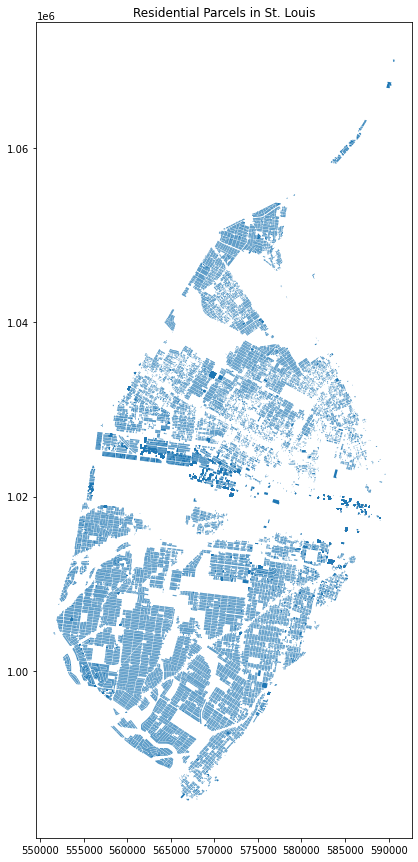

In [27]:
# visualize the data
gdf_parcels.plot(figsize=(15,15))
plt.title("Residential Parcels in St. Louis")


In [29]:
# examine the CRS info - note the units, as we will need to consider this info when computing area
gdf_parcels.crs

<Projected CRS: EPSG:26796>
Name: NAD27 / Missouri East
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Missouri - counties of Bollinger; Butler; Cape Girardeau; Carter; Clark; Crawford; Dent; Dunklin; Franklin; Gasconade; Iron; Jefferson; Lewis; Lincoln; Madison; Marion; Mississippi; Montgomery; New Madrid; Oregon; Pemiscot; Perry; Pike; Ralls; Reynolds; Ripley; Scott; Shannon; St Charles; St Francois; St Louis; Ste. Genevieve; Stoddard; Warren; Washington; Wayne.
- bounds: (-91.97, 35.98, -89.1, 40.61)
Coordinate Operation:
- name: Missouri CS27 East zone
- method: Transverse Mercator
Datum: North American Datum 1927
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

#### Compute the area (in sq. miles) of the residiential parcels

In [32]:
# find area of each parcel, convert to sq. miles, and store in a new column
gdf_parcels['area_sq_mi'] = (gdf_parcels['geom'].area / (27878400.0)) 
# sum the values in the new column to find the total area
area_res = sum(gdf_parcels['area_sq_mi'])
print("Total area of residential parcels = {0:.3f} square miles.".format(area_res))


Total area of residential parcels = 25.778 square miles.


#### Pull nonrestricted area geometry from PostGIS database

In [41]:
# create sql statement and pull from db into a geopandas dataframe
# query the table and read data into a geodf 
sql = "select * from stlnonrestrictedresparcels;"
gdf_res_remain = gpd.read_postgis(sql, conn)
gdf_res_remain.head()


,handle,asdtotal,nbrofbldgsres,geom
0,10099008011,48000,1,"POLYGON ((277147.613 310174.811, 277142.498 31..."
1,10099008011,249700,1,"POLYGON ((277147.613 310174.811, 277142.498 31..."
2,10099008011,278400,1,"POLYGON ((277147.613 310174.811, 277142.498 31..."
3,10099008011,161900,1,"POLYGON ((277147.613 310174.811, 277142.498 31..."
4,10099008011,169800,1,"POLYGON ((277147.613 310174.811, 277142.498 31..."


In [42]:
# # Type 2) dissolve the zoning data into a multipolys split out by layer description 
# # we only need the 'geometry' and our constant value column. Downselect to those to help clean up the output.
# # gdf_zoning_descr_flat = gdf_zoning[['geom','layer']].dissolve(by='layer')
# gdf_remain_descr_flat = gdf_res_nonrestricted.dissolve(by='layer')


In [43]:
# gdf_remain_descr_flat

Text(0.5, 1.0, 'Non-Restricted Residential Parcel Area in St. Louis')

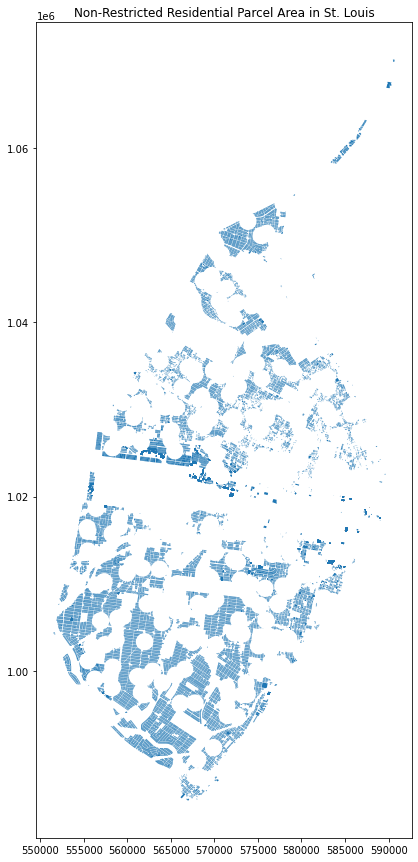

In [47]:
# visualize the data
gdf_res_remain.plot(figsize=(15,15))
plt.title("Non-Restricted Residential Parcel Area in St. Louis")


In [44]:
# examine the CRS info - note the units, as we will need to consider this info when computing area
gdf_res_remain.crs

<Projected CRS: EPSG:6512>
Name: NAD83(2011) / Missouri East
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Missouri - counties of Bollinger; Butler; Cape Girardeau; Carter; Clark; Crawford; Dent; Dunklin; Franklin; Gasconade; Iron; Jefferson; Lewis; Lincoln; Madison; Marion; Mississippi; Montgomery; New Madrid; Oregon; Pemiscot; Perry; Pike; Ralls; Reynolds; Ripley; Scott; Shannon; St Charles; St Francois; St Louis; Ste. Genevieve; Stoddard; Warren; Washington; Wayne.
- bounds: (-91.97, 35.98, -89.1, 40.61)
Coordinate Operation:
- name: SPCS83 Missouri East zone (meters)
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

This data is in a CRS with units of **meters**. We need to convert it so that it matches the other geodataframe.

In [45]:
# make sure our datasets are using the same CRS!
print('Starting all residential (gdf_parcels) CRS:', gdf_parcels.crs)
print('Starting non-restricted residential (gdf_res_remain) CRS:', gdf_res_remain.crs)
print('------------')

# convert to a common CRS
gdf_res_remain = gdf_res_remain.to_crs(gdf_parcels.crs)
print('New non-restricted residential area (gdf_res_remain) CRS:', gdf_res_remain.crs)


Starting all residential (gdf_parcels) CRS: epsg:26796
Starting non-restricted residential (gdf_res_remain) CRS: epsg:6512
------------
New non-restricted residential area (gdf_res_remain) CRS: epsg:26796


#### Compute the area (in sq. miles) of the dataset presented above.

In [48]:
# find area of each parcel, convert to sq. miles, and store in a new column
gdf_res_remain['area_sq_mi'] = (gdf_res_remain['geom'].area / (27878400.0)) 
# sum the values in the new column to find the total area
area_res_remain = sum(gdf_res_remain['area_sq_mi'])
print("Total residential parcel area after restrictions applied = {0:.3f} square miles.".format(area_res_remain))


Total residential parcel area after restrictions applied = 13.999 square miles.


In [51]:
# compute some basic stats
area_diff = area_res - area_res_remain
area_diff_percent = area_diff / area_res * 100


### Work up some value-based summary info

In [104]:
# generate summary info from each dataset
# df1 = pd.Series(gdf_parcels['asdtotal'].describe().apply(lambda x: format(x, 'f')), name = 'all_parcels')
# df2 = pd.Series(gdf_res_remain['asdtotal'].describe().apply(lambda x: format(x, 'f')), name = 'unrestricted_parcels')
df1 = gdf_parcels['asdtotal'].describe()
df2 = gdf_res_remain['asdtotal'].describe()

# combine summaries into a single dataframe with appropriate column names
asd_summary = pd.merge(df1, df2, right_index = True, left_index = True)
asd_summary.columns = ['all_parcels','unrestricted_parcels']
asd_summary.dtypes


all_parcels             float64
unrestricted_parcels    float64
dtype: object

In [106]:
# compute differncees
asd_summary['delta'] = asd_summary['unrestricted_parcels'] - asd_summary['all_parcels']
asd_summary['delta_per'] = asd_summary['delta'] / asd_summary['all_parcels'] * 100
asd_summary

,all_parcels,unrestricted_parcels,delta,delta_per
count,9.866800e+04,5.593100e+04,-42737.000000,-43.313942
mean,2.189593e+04,2.386251e+04,1966.575527,8.981465
std,2.888587e+04,3.231233e+04,3426.461180,11.862068
min,0.000000e+00,0.000000e+00,0.000000,NaN
25%,4.510000e+03,5.700000e+03,1190.000000,26.385809
50%,1.697000e+04,1.940000e+04,2430.000000,14.319387
75%,3.086000e+04,3.189000e+04,1030.000000,3.337654
max,3.761500e+06,3.761500e+06,0.000000,0.000000


## Results

In [109]:
# convert to global CRS in degress for more intuitive plotting/presentation
gdf_parcels = gdf_parcels.to_crs(4326)
gdf_res_remain = gdf_res_remain.to_crs(4326)


In [142]:
# work up some descriptive text to lay over the plots
text1 = "Area = {0:.3f} mi².".format(area_res)
print(text1)
text2 = "Area = {0:.3f} mi².\n Reduction of {1:.2f}%".format(area_res_remain,area_diff_percent)
print(text2) 


Area = 25.778 mi².
Area = 13.999 mi².
 Reduction of 45.69%


<AxesSubplot:title={'center':'Remaining Residential Parcel Area in St. Louis - After Restrictions Applied'}>

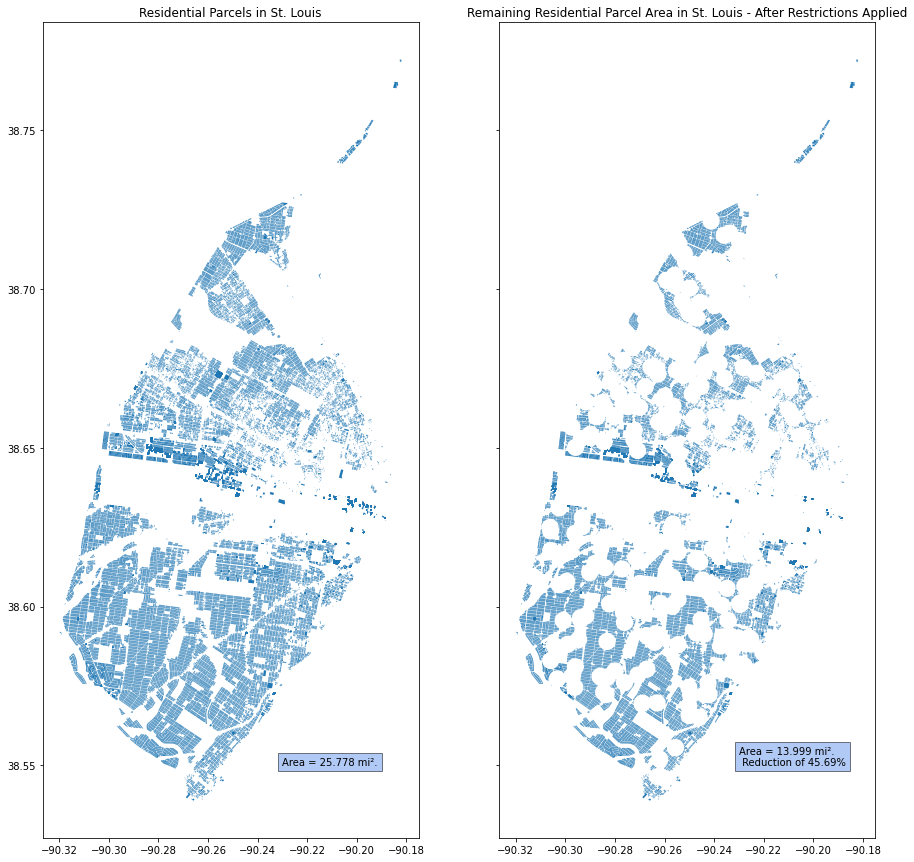

In [143]:
# same plots as above, but with before and after presentation
# visualize these two results side by side
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.set_title('Residential Parcels in St. Louis')
ax2.set_title('Remaining Residential Parcel Area in St. Louis - After Restrictions Applied')

ax1.text(-90.23, 38.55, text1, bbox=dict(facecolor='cornflowerblue', alpha=0.5))
ax2.text(-90.23, 38.55, text2, bbox=dict(facecolor='cornflowerblue', alpha=0.5))

gdf_parcels.plot(ax=ax1)
gdf_res_remain.plot(ax=ax2)


In [138]:
# output some summary info
print("Livable area in St. Louis City for a registered sex offender is {0:.3f} square miles.".format(area_res_remain))
print("This is a reduction of {0:.3f} square miles (-{1:.2f}%) ".format(area_diff,area_diff_percent) + 
      "compared to the total livable residential area of {0:.3f} square miles.".format(area_res))


Livable area in St. Louis City for a registered sex offender is 13.999 square miles.
This is a reduction of 11.779 square miles (-45.69%) compared to the total livable residential area of 25.778 square miles.


In [55]:
#close connection to the db
conn.close()